# Supervised Machine Learning with PySpark

We will be using the Orange Telecom Churn Dataset for this tutorial. This is a relatively well-known data set describing customer turnover in the telecommunications industry. The data we use are being hosted at [https://www.sgi.com/tech/mlc/db/churn.all](https://www.sgi.com/tech/mlc/db/churn.all).

In [5]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests, os, sys
import pyspark

warnings.filterwarnings('ignore')
pd.options.display.mpl_style = 'default'

%matplotlib inline

In [6]:
pyspark.__version__

'2.1.1+without.hadoop'

## Connect to the Spark server

We will be using the SparkSession (`spark`) to access our spark cluster..

In [7]:
# spark = pyspark.sql.SparkSession.builder. shift tab 
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# SparkSession (supplanted spark context) is a conduit to access all spark functionality, 
# ONLY one single sparksession exists per JVM

[BTW: pyspark sits on top of Java api](http://aseigneurin.github.io/2016/09/01/spark-calling-scala-code-from-pyspark.html)

## Obtain the data

We begin by reading in our data file.     
(don't forget to scp churn.csv from the class repo)

When we import the data below, the schema (which is similar to a schema in SQL or dtypes in Pandas) has been inferred based on the data.

In [8]:
# read.csv is very similar to the Pandas version

data = spark.read.csv('churn.csv',
                     sep=',',
                     inferSchema=True,
                     header=True)

data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account Length: integer (nullable = true)
 |-- Area Code: integer (nullable = true)
 |-- Phone: string (nullable = true)
 |-- Int'l Plan: string (nullable = true)
 |-- VMail Plan: string (nullable = true)
 |-- VMail Message: integer (nullable = true)
 |-- Day Mins: double (nullable = true)
 |-- Day Calls: integer (nullable = true)
 |-- Day Charge: double (nullable = true)
 |-- Eve Mins: double (nullable = true)
 |-- Eve Calls: integer (nullable = true)
 |-- Eve Charge: double (nullable = true)
 |-- Night Mins: double (nullable = true)
 |-- Night Calls: integer (nullable = true)
 |-- Night Charge: double (nullable = true)
 |-- Intl Mins: double (nullable = true)
 |-- Intl Calls: integer (nullable = true)
 |-- Intl Charge: double (nullable = true)
 |-- CustServ Calls: integer (nullable = true)
 |-- Churn?: string (nullable = true)



Since there are no column headers, we can see the spark gives default names to all the columns. We will want to change that.

In [47]:
type(data)

pyspark.sql.dataframe.DataFrame

In [9]:
columns = ["state", "account_length", "area_code", "phone_number", "intl_plan", 
           "voice_mail_plan", "number_vmail_messages", 
           "total_day_minutes", "total_day_calls", "total_day_charge", 
           "total_eve_minutes", "total_eve_calls", "total_eve_charge", 
           "total_night_minutes", "total_night_calls", "total_night_charge", 
           "total_intl_minutes", "total_intl_calls", "total_intl_charge", 
           "number_customer_service_calls", "churned"]

old_columns = data.schema.names

# renaming columns is a little different with PySpark
for old,new in zip(old_columns,columns):
    data = data.withColumnRenamed(old, new)

# view dtypes
data.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: integer (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- intl_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churned: string (nullable =

So we inferred the schema and then set the column names above. However, both of these things can also be explicitly created and then provided to the `read.csv` command.

An example of a defined schema is below, where the text is the column name, then the type (string, double, boolean, double, etc.) is entered. The final `True` indicates that null values can exist.

```python
from pyspark.sql.types import StringType, DoubleType, StructType, StructField

schema = StructType([
    StructField("state", StringType(), True), 
    StructField("account_length", DoubleType(), True), 
    StructField("area_code", StringType(), True), 
    ...
    ...
    StructField("churned", StringType(), True)])
```

Now, let's preview the data as a Pandas dataframe.

In [10]:
# function to select a few rows of data, convert to a Pandas dataframe, and transpose
def preview(df, n=3):
    return pd.DataFrame(df.take(n), columns=df.columns)

preview(data)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.


## Data exploration

Spark SQL allows us to explore data using SQL syntax. Let's examine the breakdown of churned customers. To perform SQL queries, the tables have to be registered using the `registerTempTable` method.

[more on Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html)

[Spark SQL vs DF](https://community.hortonworks.com/articles/42027/rdd-vs-dataframe-vs-sparksql.html)

In [11]:
data.registerTempTable('data')

churn_counts = spark.sql(r"""SELECT churned, COUNT(churned) AS total 
                            FROM data
                            GROUP BY churned""")
churn_counts.show()

+-------+-----+
|churned|total|
+-------+-----+
|  True.|  483|
| False.| 2850|
+-------+-----+



Above, we can see that there is a period at the end of the True/False values in the churned column. (There is also a space at the beginning, but that is less obvious.) We will clean all of these issues up later.

Let's examine the churn in the states with the most subscribers. First, determine the 10 states with the most subscribers.

In [12]:
state_customer_counts = spark.sql(r"""SELECT state, COUNT(state) AS total 
                                     FROM data 
                                     GROUP BY state 
                                     ORDER BY total desc 
                                     LIMIT 10""")
state_customer_counts.show()

+-----+-----+
|state|total|
+-----+-----+
|   WV|  106|
|   MN|   84|
|   NY|   83|
|   AL|   80|
|   OR|   78|
|   OH|   78|
|   WI|   78|
|   WY|   77|
|   VA|   77|
|   CT|   74|
+-----+-----+



In [13]:
state_churn_counts = spark.sql(r"""SELECT state, COUNT(churned) as churned
                                  FROM data
                                  WHERE churned LIKE '%True%'
                                  GROUP BY state""")

state_churn_counts.show(10)


+-----+-------+
|state|churned|
+-----+-------+
|   AZ|      4|
|   SC|     14|
|   LA|      4|
|   MN|     15|
|   NJ|     18|
|   DC|      5|
|   OR|     11|
|   VA|      5|
|   RI|      6|
|   WY|      9|
+-----+-------+
only showing top 10 rows



These are actual PySpark dataframes and they can be joined using either PySpark or SQL. First the join using SQL.

In [14]:
type(state_churn_counts)

pyspark.sql.dataframe.DataFrame

In [15]:
# register the tables with SQL
state_customer_counts.registerTempTable('state_customer_counts')
state_churn_counts.registerTempTable('state_churn_counts')

# join using SQL
combined_state_data = spark.sql(r"""SELECT cust_cts.state, churned, total
                                   FROM state_customer_counts AS cust_cts
                                   INNER JOIN state_churn_counts AS churn_cts
                                   ON cust_cts.state = churn_cts.state""")
combined_state_data.show()

+-----+-------+-----+
|state|churned|total|
+-----+-------+-----+
|   WV|     10|  106|
|   MN|     15|   84|
|   NY|     15|   83|
|   AL|      8|   80|
|   OR|     11|   78|
|   WI|      7|   78|
|   OH|     10|   78|
|   VA|      5|   77|
|   WY|      9|   77|
|   CT|     12|   74|
+-----+-------+-----+



PySpark also allows dataframes to be joined and sorted in a fashion similar to Pandas.   
SQL syntax is slightly more effecient.

In [16]:
combined_state_data2 = state_churn_counts.join(state_customer_counts, 
                                               on='state', 
                                               how='inner')

# sort inversely by total column
combined_state_data2 = combined_state_data2.sort(combined_state_data2.total.desc())

combined_state_data2.show()

+-----+-------+-----+
|state|churned|total|
+-----+-------+-----+
|   WV|     10|  106|
|   MN|     15|   84|
|   NY|     15|   83|
|   AL|      8|   80|
|   OH|     10|   78|
|   WI|      7|   78|
|   OR|     11|   78|
|   WY|      9|   77|
|   VA|      5|   77|
|   CT|     12|   74|
+-----+-------+-----+



In [17]:
preview(data)

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.


## Data cleaning

The columns that are supposed to be boolean (`intl_plan`, `voice_mail_plan`, and `churned`) need some cleaning and their types need to be converted from string to boolean.

In [18]:
from pyspark.sql.functions import udf

# columns not used in analysis
for field in ['state', 'area_code', 'phone_number']:
    data = data.drop(field)

def trim(string):
    return (string
            .strip()                # string columns have spaces due to csv file format
            .replace('.','')        # remove period at end of each line
            .replace('yes','True')  # convert yes/no to True/False
            .replace('no','False'))

# udf converts a function into one that can be applied over
# a dataframe column. This is kind of like Pandas apply/map functionality.
trim = udf(trim)
    
# apply the function to every string column
for dtype in data.dtypes: # dtypes : returns tuples,: ('account_length', 'int')
    column = dtype[0]
    if dtype[1] == 'string':
        data = data.withColumn(column, trim(data[column]))  #with shift-tab? 

# boolean types converted to integers
for column in ['intl_plan', 'voice_mail_plan']:
    data = data.withColumn(column, data[column].cast('boolean').cast('int'))
    
# predictors have to be of type double for many of Spark's ML models
data = data.withColumn('churned', data['churned'].cast('boolean').cast('double'))

Now that we've cleaned the data, let's make correlation plots of variables.

In [19]:
type(data)

pyspark.sql.dataframe.DataFrame

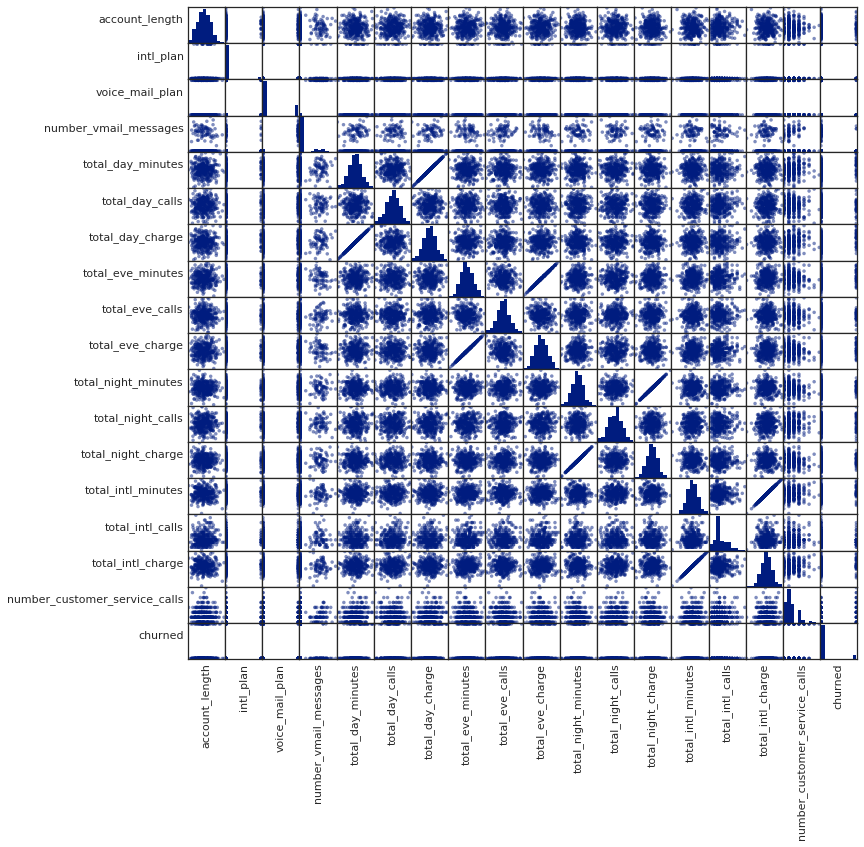

In [20]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

# get the names of columns that are integers or doubles
numeric_features = [t[0] for t in data.dtypes if t[1] in ['int', 'double']]

# sample 10% of this data and convert to a Pandas dataframe
sampled_data = data.select(numeric_features).sample(False, 0.10).toPandas()

# make the scatter plot
axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

As we can see from above, there are four pairs of variables that are highly correlated with each other, corresponding to charge and minutes for day, night, evening, and international. This makes sense since the charge like reflects a per-minute rate. We will remove the charge column for each of these.

In [21]:
# remove one of each pair of highly correlated columns
for field in ['total_day_charge', 'total_night_charge',
              'total_eve_charge', 'total_intl_charge']:
    data = data.drop(field)
    
preview(data)

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0.0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0.0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0.0


## Split data

Before modelling, the data are split into train and test data sets. 

We could also do a three-way split for train, validation, and test data using the `randomSplit` method:

```python
train, valid, test = data.randomSplit([0.6, 0.2, 0.2], seed=42)
```

Finally, it is also possible to do a stratified split using the `sampleBy` method of the dataframe.

In [22]:
train, test = data.randomSplit([0.7, 0.3], seed=42)

## Combine feature columns

Inputs to Scikit-learn models have the data split into X-arrays/dataframes (features) and Y-arrays/dataframes (predictors). PySpark expects both the features and the predictor to be in a single dataframe. However, all the features have to be combined into a single column containing a list of the feature values. To accomplish this, we use [`VectorAssembler`](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

Note that VectorAssembler uses transform. This is just like the second step of Scikit-learn's feature transformers for normalization, etc.

We will also be using [`MinMaxScaler`](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.MinMaxScaler) to scale the features for the logistic regression model. (Note that scaling isn't strictly required with logistic regression, but it doesn't hurt and it's good to get experience with how these feature modifications work.)

In the cells below, use VectorAssembler to create a packed feature column and then use MinMaxScaler to scale this packed column.

In [23]:
# lets transpose output of the preview function

def preview(df, n=3):
    return pd.DataFrame(df.take(n), columns=df.columns).T

preview(train)

,0,1,2
account_length,1.0,1.0,1.0
intl_plan,0.0,0.0,0.0
voice_mail_plan,0.0,0.0,1.0
number_vmail_messages,0.0,0.0,26.0
total_day_minutes,123.8,196.1,146.6
total_day_calls,113.0,107.0,68.0
total_eve_minutes,236.2,296.5,172.8
total_eve_calls,77.0,82.0,67.0
total_night_minutes,73.2,211.5,173.8
total_night_calls,81.0,91.0,113.0


In [24]:
from pyspark.ml.feature import VectorAssembler

# the feature columns
features = data.schema.names[:-1]

assembler = VectorAssembler(inputCols=features, outputCol='features')

train_pack = assembler.transform(train)
test_pack = assembler.transform(test)

preview(train_pack)

,0,1,2
account_length,1,1,1
intl_plan,0,0,0
voice_mail_plan,0,0,1
number_vmail_messages,0,0,26
total_day_minutes,123.8,196.1,146.6
total_day_calls,113,107,68
total_eve_minutes,236.2,296.5,172.8
total_eve_calls,77,82,67
total_night_minutes,73.2,211.5,173.8
total_night_calls,81,91,113


In [25]:
# (optional) remove the columns packed into the feature vector
for field in features:
    train_pack = train_pack.drop(field)
    test_pack  = test_pack.drop(field)
    
preview(train_pack)

,0,1,2
churned,0,0,0
features,"[1.0, 0.0, 0.0, 0.0, 123.8, 113.0, 236.2, 77.0...","[1.0, 0.0, 0.0, 0.0, 196.1, 107.0, 296.5, 82.0...","[1.0, 0.0, 1.0, 26.0, 146.6, 68.0, 172.8, 67.0..."


In [26]:
from pyspark.ml.feature import MinMaxScaler

minmaxscale = MinMaxScaler(inputCol='features', outputCol='features_scaled')
minmaxscale = minmaxscale.fit(train_pack)

train_pack = minmaxscale.transform(train_pack)
test_pack  = minmaxscale.transform(test_pack)

In [27]:
preview(test_pack)

,0,1,2
churned,0,0,1
features,"[1.0, 0.0, 0.0, 0.0, 144.8, 107.0, 112.5, 66.0...","[1.0, 0.0, 0.0, 0.0, 175.2, 74.0, 151.7, 79.0,...","[1.0, 0.0, 0.0, 0.0, 182.1, 106.0, 134.9, 106...."
features_scaled,"[0.0, 0.0, 0.0, 0.0, 0.412770809578, 0.6564417...","[0.0, 0.0, 0.0, 0.0, 0.499429874572, 0.4539877...","[0.0, 0.0, 0.0, 0.0, 0.519099201824, 0.6503067..."


## Basic model building

Now we get to the fun part--machine learning! 

PySpark has two machine learning libraries:

1. MLlib: older, based on RDDs, more complete, but no additional features are being added as of Spark 2.0
2. ML: the *future*, based on DataFrames, less feature complete than MLlib but this is improving

Often the name MLlib is used to refer to both libraries, so context is important and this can be confusing. We will be using ML whenever possible.

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
                                      GBTClassifier, LogisticRegression

We will begin by training a number of models and evaluating the results. Notice that the `fit` method is similar to Scikit-learn. However, `transform` is used with PySpark instead of `predict`. The syntax is similar among different PySpark ML models, though.

Try to train the logistic regression model with the scaled features column. For the other models, just use the unscaled features.

In [29]:
# logistic regression
lr = LogisticRegression(labelCol='churned', 
                        featuresCol='features_scaled',  # train scaled features
                        predictionCol='prediction')

lr_model = lr.fit(train_pack)
lr_pred = lr_model.transform(test_pack)  # returns another dataframe, see below!

# Decision Tree (depth = 2)
dt = DecisionTreeClassifier(maxDepth=2, 
                            labelCol='churned', 
                            featuresCol='features',   
                            predictionCol='prediction')

dt_model = dt.fit(train_pack)
dt_pred = dt_model.transform(test_pack)

# Random Forest (also of depth = 2)
rf = RandomForestClassifier(maxDepth=2, 
                            labelCol='churned',
                            featuresCol='features',
                            predictionCol='prediction')

rf_model = rf.fit(train_pack)
rf_pred = rf_model.transform(test_pack)

# Gradient Boosted Tree (depth = 2)
gbt = GBTClassifier(maxDepth=2, 
                    labelCol='churned', 
                    featuresCol='features',
                    predictionCol='prediction')

gbt_model = gbt.fit(train_pack)
gbt_pred = gbt_model.transform(test_pack)

In [30]:
preview(lr_pred)   # seems strange to have extra data in the prediction dataframe, 
                # but we'll see that we'll leverage this later

,0,1,2
churned,0,0,1
features,"[1.0, 0.0, 0.0, 0.0, 144.8, 107.0, 112.5, 66.0...","[1.0, 0.0, 0.0, 0.0, 175.2, 74.0, 151.7, 79.0,...","[1.0, 0.0, 0.0, 0.0, 182.1, 106.0, 134.9, 106...."
features_scaled,"[0.0, 0.0, 0.0, 0.0, 0.412770809578, 0.6564417...","[0.0, 0.0, 0.0, 0.0, 0.499429874572, 0.4539877...","[0.0, 0.0, 0.0, 0.0, 0.519099201824, 0.6503067..."
rawPrediction,"[3.12351646485, -3.12351646485]","[3.32601011821, -3.32601011821]","[1.06224682827, -1.06224682827]"
probability,"[0.957852420712, 0.0421475792875]","[0.965310411411, 0.0346895885888]","[0.743119682921, 0.256880317079]"
prediction,0,0,0


## Model evaluation

PySpark also has error metrics that are similar to those found in Scikit-learn. They are divided into metrics appropriate only for binary classifications (ROC and Precision-Recall curve related metrics) and those that also apply to multi-class classifications.

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
                                  MulticlassClassificationEvaluator

accuracy = MulticlassClassificationEvaluator(labelCol='churned', 
                                             predictionCol='prediction',
                                             metricName='accuracy')

precision = MulticlassClassificationEvaluator(labelCol='churned', 
                                              predictionCol='prediction',
                                              metricName='weightedPrecision')

recall = MulticlassClassificationEvaluator(labelCol='churned', 
                                           predictionCol='prediction',
                                           metricName='weightedRecall')

f1 = MulticlassClassificationEvaluator(labelCol='churned', 
                                       predictionCol='prediction',
                                       metricName='f1')

areaROC = BinaryClassificationEvaluator(labelCol='churned',
                                        rawPredictionCol='prediction',
                                        metricName='areaUnderROC')

areaPR = BinaryClassificationEvaluator(labelCol='churned',
                                       rawPredictionCol='prediction',
                                       metricName='areaUnderPR')

These metrics can be used to create a table of the values for each model's predictions.

In [32]:
# the error metrics
metrics = [accuracy, precision, recall, f1, areaROC, areaPR]
metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC', 'areaPR']

# the predictions from each model
predictions = [lr_pred, dt_pred, rf_pred, gbt_pred]
predict_labels = ['LR', 'DT', 'RF', 'GBT']

eval_list = list()

# for each model's predictions, calculate error metrics
# and add to a Pandas series
for pred in zip(predict_labels, predictions):
    name = pred[0]
    predict = pred[1]
    
    metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict))   # ex: accuracy.evaluate(lr_pred) 
                                 for x in zip(metric_labels, metrics)]),
                            name=name)
    eval_list.append(metric_vals)
    
    
eval_list[0]

accuracy     0.858471
areaPR       0.428441
areaROC      0.597014
f1           0.834503
precision    0.829376
recall       0.858471
Name: LR, dtype: float64

In [33]:
# combine all the series into a dataframe
eval_df = pd.concat(eval_list, axis=1).T
eval_df

,accuracy,areaPR,areaROC,f1,precision,recall
LR,0.858471,0.428441,0.597014,0.834503,0.829376,0.858471
DT,0.888430,0.622011,0.749234,0.885556,0.883461,0.888430
RF,0.857438,0.574878,0.503597,0.792652,0.877783,0.857438
GBT,0.919421,0.723091,0.788286,0.914943,0.914427,0.919421


Similar metrics (plus a confusion matrix) are also available in MLlib, the older library. We will have to convert the dataframe to an RDD to use these metrics. These metrics have the advantage that they are a little easier (and less verbose) to implement. There is also a confusion matrix function.

In [34]:
# in case we want confusion matrices.. 

from pyspark.mllib.evaluation import BinaryClassificationMetrics, \
                                     MulticlassMetrics

# let's make a function this time so it's reuseable

def evaluate_model_predictions(prediction_list, prediction_labels):
    
    eval_list = list()

    # for each model's predictions, calculate error metrics
    # and add to a Pandas series
    for pred in zip(prediction_labels, prediction_list):
        name = pred[0]
        predict = pred[1]

        # here is where the prediction dataframe is converted to an rdd
        predict_rdd = predict[['prediction', 'churned']].rdd
        b_metrics = BinaryClassificationMetrics(predict_rdd)
        m_metrics = MulticlassMetrics(predict_rdd)

        metric_vals = pd.Series({'accuracy'        : m_metrics.accuracy,
                                 'precision'       : m_metrics.precision(0),
                                 'recall'          : m_metrics.recall(0),
                                 'f1'              : m_metrics.fMeasure(),
                                 'areaROC'         : b_metrics.areaUnderROC,
                                 'areaPR'          : b_metrics.areaUnderPR,
                                 'confusion matrix': (m_metrics.confusionMatrix()
                                                      .toArray().astype('int'))},
                                name=name)
        eval_list.append(metric_vals)

    # combine all the series into a dataframe
    eval_df = pd.concat(eval_list, axis=1).T
    
    metric_labels = ['accuracy', 'precision', 'recall', 'f1', 'areaROC', 'areaPR', 'confusion matrix']
    eval_df = eval_df[metric_labels]
    
    return eval_df


# the predictions from each model
predictions = [lr_pred, dt_pred, rf_pred, gbt_pred]
predict_labels = ['LR', 'DT', 'RF', 'GBT']

eval_df2 = evaluate_model_predictions(predictions, predict_labels)
eval_df2

,accuracy,precision,recall,f1,areaROC,areaPR,confusion matrix
LR,0.858471,0.881898,0.963812,0.858471,0.597014,0.428441,"[[799, 30], [107, 32]]"
DT,0.88843,0.926627,0.944511,0.88843,0.749234,0.622011,"[[783, 46], [62, 77]]"
RF,0.857438,0.857291,1,0.857438,0.503597,0.574878,"[[829, 0], [138, 1]]"
GBT,0.919421,0.936121,0.972256,0.919421,0.788286,0.723091,"[[806, 23], [55, 84]]"


Note that the calculations for precision, recall, and f1 are a little different from the first set. This is because the dataframe calculations use weighted precision and recall.

## Combine into pipeline

Any feature transformations and model fitting can be combined into a pipeline. Pipelines are useful because:

1. The data can be split  *before* any transformations that may lead to leakage of the test data.
2. Simultaneously ensure that the split data sets are treated identically.

We don't do much in this example for feature transformation other than assembling all the features into one column and scaling, but let's use that to create a pipeline for the logistic regression model we used above.

If we *did* do extensive feature engineering, then having a pipeline would be extremely beneificial. (Just like in scikit-learn.)

In [35]:
from pyspark.ml import Pipeline

# the pipline
pipeline = Pipeline(stages=[assembler, minmaxscale, lr]) 

# fit and transform
lr_model2 = pipeline.fit(train)
lr_pred2 = lr_model2.transform(test)

# the results are the same for GBT as the second table above
evaluate_model_predictions([lr_pred2], ['LR'])

,accuracy,precision,recall,f1,areaROC,areaPR,confusion matrix
LR,0.858471,0.881898,0.963812,0.858471,0.597014,0.428441,"[[799, 30], [107, 32]]"


## Grid search and cross validation

PySpark also has gridsearch and crossvalidation functionalities, similar to Scikit-learn's. Let's do a quick example with GradientBoostedTrees.

In [36]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# the GradientBoostedTree model
gbt2 = GBTClassifier(featuresCol='features',
                     labelCol='churned', 
                     predictionCol='prediction')
 
# the pipline
pipeline = Pipeline(stages=[assembler, gbt2]) 

# the parameter grid--we'll optimize maxDepth and stepSize
paramgrid = (ParamGridBuilder().addGrid(gbt2.maxDepth, [6])
                               .addGrid(gbt2.stepSize, [0.001, 0.01, 0.1, 1.0]).build())

# use f1 score as the evaluation metric for best model 
evaluator = MulticlassClassificationEvaluator(labelCol='churned', 
                                              predictionCol='prediction', 
                                              metricName='f1') 

# use 3-fold cross validation 
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramgrid, 
                          evaluator=evaluator, 
                          numFolds=3) 

gbt2_model = crossval.fit(train) 

Much like with Scikit-learn's gridsearch function, we can probe for the best model and view its attributes. 

First, we have to select the best model, though.

In [37]:
# return the best pipeline based on f1 score
best_pipeline = gbt2_model.bestModel

# return the best GBT model, which is the second step of the pipeline
best_gbt_model = best_pipeline.stages[1]

Unfortunately, not all model parameters can be extracted with PySpark, but we can extract the individual trees for GradientBoostedTrees and then examine them.

In [38]:
# how many trees were there?
len(best_gbt_model.trees)

20

In [39]:
# list some of the trees
best_gbt_model.trees[:5]

[DecisionTreeRegressionModel (uid=dtr_d233b11d0c4e) of depth 6 with 81 nodes,
 DecisionTreeRegressionModel (uid=dtr_ee4396305dfd) of depth 6 with 113 nodes,
 DecisionTreeRegressionModel (uid=dtr_dab7853a91e5) of depth 6 with 121 nodes,
 DecisionTreeRegressionModel (uid=dtr_cdd0a059e4fd) of depth 6 with 123 nodes,
 DecisionTreeRegressionModel (uid=dtr_f4247c033d96) of depth 6 with 123 nodes]

In [40]:
# what were their weights in the GBT model?
best_gbt_model.treeWeights[:5]

[1.0,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001]

In [41]:
# what was the best depth?
[x.depth for x in best_gbt_model.trees]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

We can also examine feature importances, much like Scikit-learn.

In [42]:
# extract feature importances
feature_importances = best_gbt_model.featureImportances.toArray()

# extract feature names, except for the predictor
feature_names = train.columns[:-1]

feature_series = (pd.Series(dict(zip(feature_names, feature_importances)))
                  .sort_values(ascending=True))

feature_series

total_eve_calls                  0.017513
number_vmail_messages            0.023655
voice_mail_plan                  0.029033
account_length                   0.033843
total_day_calls                  0.043314
intl_plan                        0.052919
total_night_calls                0.067092
number_customer_service_calls    0.068053
total_intl_calls                 0.083273
total_night_minutes              0.096935
total_intl_minutes               0.108958
total_eve_minutes                0.171583
total_day_minutes                0.203829
dtype: float64

Let's plot them in a bar graph. Total minutes (day, evening, night, or international) are the biggest predictor of churn.

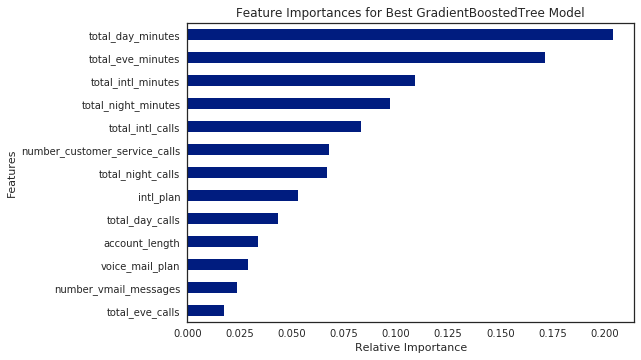

In [43]:
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = feature_series.plot(kind='barh')
_ = ax.set(xlabel='Relative Importance', 
           ylabel='Features', 
           title='Feature Importances for Best GradientBoostedTree Model')

fig = plt.gcf()

# save to the folder shared with the AWS instance
# this is the same folder as the notebook is executed from
# so a path is not required
fig.savefig('feature_importances.pdf')

## Measure error on test data set

Let's use the best model to measure the error on the test data set. We used f1 score for the gridsearch metric, and as can be seen below, this improved from 0.919 to 0.949 with the gridsearch.

In [44]:
gbt_pred_test = best_pipeline.transform(test)

evaluate_model_predictions([gbt_pred_test], ['GBT_GridSearch'])

,accuracy,precision,recall,f1,areaROC,areaPR,confusion matrix
GBT_GridSearch,0.94938,0.963183,0.978287,0.94938,0.877633,0.833073,"[[811, 18], [31, 108]]"


## Save the model for later use

PySpark trained models can be saved for later use and then reloaded. Conceptually, this is much like pickling, except the output is a directory.

In [45]:
model_output_name = 'gbt_model_pipeline_crossval'

# models will not overwrite existing ones of the same name
import shutil
if os.path.exists(model_output_name):
    shutil.rmtree(model_output_name)

best_gbt_model.save(model_output_name)

! ls {model_output_name}

data  metadata	treesMetadata


Now the model can be loaded here or in other analysis. Note that we have to import the *model* instance to load the file. Previously, we had only imported the classifier.

In [46]:
from pyspark.ml.classification import GBTClassificationModel

reloaded_model = GBTClassificationModel.load(model_output_name)
reloaded_model

GBTClassificationModel (uid=GBTClassifier_4ea4a04b9ac69ac767a9) with 20 trees